## Automate: create, detect, write high_res blend 
started: Aug 18th 2020 <br>
edit: Aug 21th 2020

In [1]:
from __future__ import print_function
import argparse
import os
import random
from skimage.transform import downscale_local_mean
from scipy.ndimage import zoom
import matplotlib.pyplot as plt
import astropy.io.fits as pyfits
import numpy as np

import astropy.wcs as wcs
from astropy import units as u
from astropy.coordinates import SkyCoord
from scipy import ndimage
from PIL import Image
from photutils import create_matching_kernel


import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import torch.nn.functional as F


from astropy.convolution import convolve

from skimage.feature import blob_dog, blob_log, blob_doh

from peak_finding import (
    PeakFinder,
    find_peaks,
)

import cv2

device = torch.device("cpu")

batchSize = 64          # input batch size
imageSize = 64           # the height / width of the input image to network
ngf = 64
ndf = 64
nz = 1000
ngpu = 0    #number of GPUs to use
netG = ''
manualSeed = random.randint(1, 10000)

torch.manual_seed(manualSeed)
device = torch.device("cpu")

nc = 1

class Shoobygen(nn.Module):

    def __init__(self,ngpu):
        super(Shoobygen, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            
            nn.Conv2d(1, ngf * 4, 7, 2, 2, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            
            
            nn.ConvTranspose2d( ngf*4, ngf * 2, 6, 3, 2,dilation=2, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(ngf * 2, nc, 3, 2, 2, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        if input.is_cuda and self.ngpu > 1:
            output = nn.parallel.data_parallel(self.main, input, range(self.ngpu))
            output1 = output[:,:,:,:]

        else:
            output = self.main(input)
            output1 = output[:,:,:,:]

        return output1

netS = Shoobygen(ngpu).to(device)
netS.load_state_dict(torch.load('/Users/shemmati/Dropbox/kinematic_lensing/disks/trained_weights/netG_epoch_900.pth',map_location='cpu'))

%matplotlib inline

def radec2xy(ra,dec,wc):
    coords = SkyCoord(ra,dec, unit='deg')
    a=wcs.utils.skycoord_to_pixel(coords, wc, origin=0,mode=u'wcs')
    return a[0],a[1]
    
def cut(ra,dec,andaze,filename):
    '''gets coordinates of the galaxy and the filter to return a cutout
    (also called a postage stamp) of the galaxy with given size'''
    hdr = pyfits.getheader(filename)#'/Users/shemmati/Desktop/GOODS/goodsn_all_wfc3_ir_f160w_060mas_v1.0_drz.fits')#
    w = wcs.WCS(hdr)
    x,y=radec2xy(ra,dec,w)
    x,y=np.int(x),np.int(y)
    im=pyfits.getdata(filename)[y-andaze:y+andaze,x-andaze:x+andaze]
    return im

def brightest_center(im, r = 20):
    
    '''This function is to check whether the central object of the 
    image is the brightest compared to its neighbors in the given cutout.
    Central is defined with a 10x10 pixel square in the center'''
    
    a0,a1 = np.unravel_index(np.argmax(im, axis=None), im.shape)
    ans = False
    if ((a0>((im.shape[0]-r)/2)) & (a0<((im.shape[0]+r)/2)) & (a1>((im.shape[1]-r)/2)) & (a1<((im.shape[0]+r)/2))):
        ans = True
    
    return ans

def go_lowres(galax,out_size=21, noise_sigma=2):
    '''This function is to take high resolution galaxy cutout and go to 
    a lower pixelscale, resolution and more noise'''
    
    from photutils import create_matching_kernel
    from skimage.transform import downscale_local_mean
    from astropy.convolution import convolve
    
    psf = pyfits.getdata('/Users/shemmati/Dropbox/kinematic_lensing/disks/psfs/psf_i.fits')
    psf = downscale_local_mean(psf,(3,3))
    psf = psf[7:-8,7:-8]
    psf_hsc = pyfits.getdata('/Users/shemmati/Dropbox/kinematic_lensing/disks/psfs/PSF_subaru_i.fits')
    psf_hsc = psf_hsc[1:42,1:42]
    kern = create_matching_kernel(psf,psf_hsc)

    im = galax+np.random.normal(0,noise_sigma,galax.shape)
    img = convolve(im,kern)
    outp = np.array(Image.fromarray(img).resize((out_size,out_size)))

    return outp

def go_lowres_tens(galax):
    device = torch.device("cpu")
    tfms = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,), (0.5,))])
    im = tfms(galax)
    gals = np.repeat(im[:,:,:,np.newaxis],1,axis = 3)
    gals =torch.tensor(gals, device="cpu").float()
    gals = gals.permute(3,0,1,2)
    inputs = gals
    real_cpu = inputs.to(device)

    psf = pyfits.getdata('/Users/shemmati/Dropbox/kinematic_lensing/disks/psfs/psf_i.fits')
    psf = downscale_local_mean(psf,(3,3))
    psf = psf[7:-8,7:-8]#[22:-22,22:-22]
    psf_hsc = pyfits.getdata('/Users/shemmati/Dropbox/kinematic_lensing/disks/psfs/PSF_subaru_i.fits')
    psf_hsc = psf_hsc[1:42,1:42]
    kern = create_matching_kernel(psf,psf_hsc)
    psfh = np.repeat(kern[:,:, np.newaxis], 1, axis=2)
    psfh = np.repeat(psfh[:,:,:,np.newaxis],1,axis = 3)
    kernel = torch.Tensor(psfh)
    kernel = kernel.permute(2,3,0,1)
    kernel =  kernel.float()
    kernel = kernel.to(device)

    im = real_cpu+0.25*torch.rand_like(real_cpu)
    downsampled = F.upsample(im,scale_factor=1/3,mode='bilinear')
    img = F.conv2d(downsampled, kernel,padding=int(((kernel.shape[3])-1)/2))
    return img[:,:,:,:]
 

In [13]:
def galblend(gals=1, lim_hmag=24, plot_it=True):
    
    '''This is to put together two candels GOODS_S galaxies into a single 64x64 cutout.
    I make sure in each cutout the central galaxy is brightest object in the cutout so 
    in rescaling and adding two components still show up. Also, one galaxy is put at 
    the center and the second in some random distance from it. both cutouts are rotated with
    a random angle. Cutouts are from HST H band for now.'''
    
    ## reading GOODS-S catalog and initial selection on objects
    gs = pyfits.getdata('../../../../WFIRST_WPS/CANDELS_fits/gds.fits')
    sel1 = (gs['zbest']>0.1)&(gs['zbest']<5.0)&(gs['CLASS_STAR']<0.95)&(gs['Hmag']<lim_hmag)&(gs['FWHM_IMAGE']>2)&(gs['FWHM_IMAGE']<10) &(gs['DECdeg']>-27.8)
    
   
    ra, dec,red,iflux = gs['RA_1'][sel1],gs['DEC_1'][sel1],gs['zbest'][sel1],gs['ACS_F814W_FLUX'][sel1]
    z2,flux2,x2,y2 = np.zeros(gals),np.zeros(gals),np.zeros(gals),np.zeros(gals)

    im = np.zeros([64,64])
   
    data1 = np.zeros([80,80])
    da1 = np.zeros([64,64])
    while not(brightest_center(data1)):
        n = np.int(np.random.uniform(0,len(ra)-1))
        data1 = cut(ra[n],dec[n],40,'/Users/shemmati/Desktop/GOODS/goodss_all_acs_wfc_f775w_060mas_v1.5_drz.fits')
        z2[0] = red[n]
        flux2[0] = iflux[n] 
    
    angle = np.random.uniform(0,180)
    s = ndimage.rotate(data1,angle,mode='nearest',reshape=False)
    da1 = s[8:-8,8:-8]
    y2[0],x2[0] = np.unravel_index(da1.argmax(), da1.shape)
    im += da1
    
    da2 = np.zeros([gals,64,64])
    
    for boz in range(gals-1):
        data2 = np.zeros([100,100])
        while not(brightest_center(data2)):
            n = np.int(np.random.uniform(0,len(ra)-1))
            data2 = cut(ra[n],dec[n],50,'/Users/shemmati/Desktop/GOODS/goodss_all_acs_wfc_f775w_060mas_v1.5_drz.fits')
            z2[boz+1],flux2[boz+1] = red[n],iflux[n]
        p,t = np.int(np.random.uniform(5,10)),np.int(np.random.uniform(5,10))
        s = data2[10+t:-10+t,10+p:-10+p]
        angle = np.random.uniform(0,180)
        so = ndimage.rotate(s,angle,mode='nearest',reshape=False)
        da2[boz] = so[8:-8,8:-8]
        y2[boz+1],x2[boz+1] = np.unravel_index(da2[boz].argmax(), da2[boz].shape)
        im += da2[boz]
    
        
    dada = np.arcsinh(im)
    rescaled = (255.0 / (dada.max()+0.05) * (dada - dada.min())).astype(np.uint8)
    final_im = Image.fromarray(rescaled)
        
     #### Detect sources on high res blend sample
    
    #psf = pyfits.getdata('../../psfs/psf_i.fits')
    #num = find_peaks(image=rescaled-np.mean(rescaled), kernel = psf,thresh=np.mean(rescaled))
    #x_esh,y_esh = [],[]
    #for boz in range(len(num)):
    #    if (10<num[boz][0]<50)&(10<num[boz][1]<50):
    #        x_esh.append(num[boz][0])
    #        y_esh.append(num[boz][1])
    
    blobs_log = blob_log(rescaled-np.mean(rescaled), min_sigma=0.1, max_sigma=5, num_sigma=20, threshold=np.mean(rescaled)/2, overlap=0.95, log_scale=True, exclude_border=False)
    blobs_log[:, 2] = blobs_log[:, 2] * np.sqrt(2) # Compute radii in the 3rd column.
    x_esh,y_esh = [],[]
    for blob in blobs_log:
        x, y, r = blob
        if ((r>1)&(10<x<50)&(10<y<50)):
            y_esh.append(y)
            x_esh.append(x)
      
    ### Reduce resolution and pixel scale to Subaru and add some noise
    lowres = go_lowres(rescaled)
    
    ### Detect sources on Lowres
    blobs_log = blob_log(lowres-np.mean(lowres), min_sigma= 2*np.std(lowres), max_sigma=5*np.std(lowres), num_sigma=20, threshold=np.mean(lowres)/2, overlap=0.95, log_scale=True, exclude_border=False)    
    x_esh_low,y_esh_low = [],[]
    for blob in blobs_log:
        x, y, r = blob
        if ((r>1)&(10<x<50)&(10<y<50)):
            y_esh_low.append(y)
            x_esh_low.append(x)

    #### Increase resolution with the trained GAN       
    lowres_tensor = go_lowres_tens(rescaled)       
    fake = netS(lowres_tensor)
    fd = fake.detach()
    fd = fd.cpu()
    GANres = fd[0,0,:,:].numpy()
    
    ### Detect sources on GANres
    blobs_log = blob_log(GANres-np.mean(GANres), min_sigma=2.5, max_sigma=5, num_sigma=20, threshold=np.mean(GANres)/2, overlap=0.95, log_scale=True, exclude_border=False)
    x_esh_fd,y_esh_fd = [],[]
    for blob in blobs_log:
        x, y, r = blob
        if ((r>1)&(10<x<50)&(10<y<50)):
            y_esh_fd.append(y)
            x_esh_fd.append(x)

    
    if plot_it:
        plt.figure(figsize=(15,6))
        n = gals+1
        
        plt.subplot(1,n+2,1)
        plt.imshow(da1,origin='lower')
        plt.scatter(x2[0],y2[0],marker='x',color='r')
        plt.text(2,55,'1, z='+str(z2[0]),color='y',fontsize=20)
        for boz in range(gals-1):
            plt.subplot(1,n+2,2+boz)
            plt.imshow(da2[boz],origin='lower')
            plt.text(2,55,str(boz+2)+', z='+str(z2[boz+1]),color='y',fontsize=20)
            plt.scatter(x2[boz+1],y2[boz+1],marker='x',color='r')
        plt.subplot(1,n+2,n)
        plt.imshow(dada,origin='lower')
        plt.text(2,55,'Sum',color='y',fontsize=20)
        plt.plot(y_esh,x_esh,'ro')
        
        plt.subplot(1,n+2,n+1)
        plt.imshow(lowres,origin='lower')
        plt.text(1.5,18,'Lowres',color='y',fontsize=20)
        #plt.plot(y_esh_low,x_esh_low,'ro')
        
        plt.subplot(1,n+2,n+2)
        plt.imshow(fd[0,0,:,:],origin='lower')
        plt.text(2,55,'GAN res',color='y',fontsize=20)
        #plt.plot(y_esh_fd,x_esh_fd,'ro')


        plt.show()
        
    return final_im,rescaled,[x2,y2,z2,flux2]

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:148: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:2941: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:3121: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for int

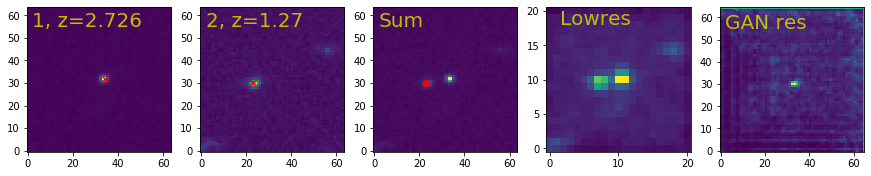

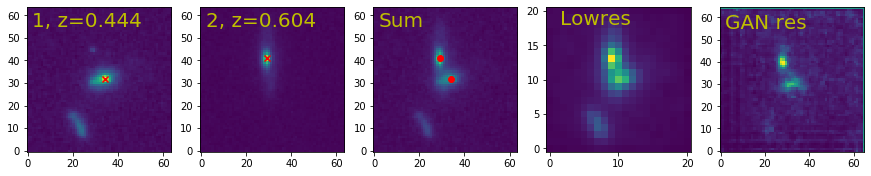

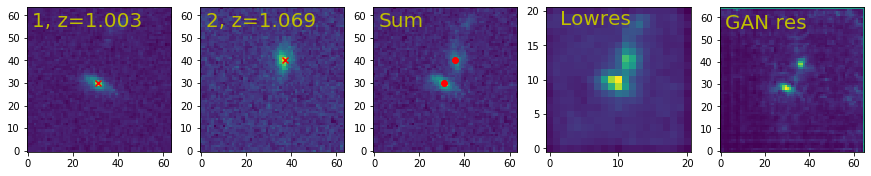

[array([31., 37.]), array([30., 40.]), array([1.003, 1.069]), array([1.09252 , 0.929099])]


In [14]:
a,galax,data = galblend(gals=2,lim_hmag=24,plot_it=True)
a,galax,data = galblend(gals=2,lim_hmag=24,plot_it=True)
a,galax,data = galblend(gals=2,lim_hmag=24,plot_it=True)
print(data)